# Supervised Repertoire Classification

While solving a sequence classification can be useful in the cases where the label applies to every sequence in a sample (such as in tetramer-sorted T-cells), there are times where the label may truly only apply to a set of sequences. For example, in the case where one may sequence tumor-infiltrating lymphocytes (TIL) and  there is a label at the repertoire/sample level such as which therapy the sample received. In this case, there may be a structural signature within a set of sequences that is predictive but not every single sequence has that signature. This is a case where we want to learn what is the structural signature buried in a set of sequenes and which sequences carry this signature.

To demo this utility of a repertoire/sample level classifier, we will first upload dat from the Rudqvist dataseet. In this dataset, 20 mice with implanted tumors were treated with 4 modes of therapy (Control, 9H10, RT, or Combo). We want to know whether the TCRrepertoire from their tumors is predictive of the therapy they received.

In [1]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_WF

# Instantiate training object
DTCR_WF = DeepTCR_WF('Tutorial')

#Load Data from directories
DTCR_WF.Get_Data(directory='../../Data/Rudqvist',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=1,count_column=2,v_beta_column=7,d_beta_column=14,j_beta_column=21)

Loading Data...
Embedding Sequences...
Data Loaded


Following loading the data, we will split our data into test/train and then train the model.

In [2]:
DTCR_WF.Get_Train_Valid_Test(test_size=0.25)
DTCR_WF.Train()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Training_Statistics: 
 Epoch: 1/10000 Training loss: 1.39319 Validation loss: 1.38840 Testing loss: 1.40941 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.25
Training_Statistics: 
 Epoch: 2/10000 Training loss: 1.37379 Validation loss: 1.38443 Testing loss: 1.39631 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.0 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 3/10000 Training loss: 1.35874 Validation loss: 1.38080 Testing loss: 1.38449 Training Accuracy: 0.5 Validation Accuracy: 0.25 Testing 

Training_Statistics: 
 Epoch: 36/10000 Training loss: 0.53901 Validation loss: 1.19063 Testing loss: 1.00913 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.75 Testing AUC: 0.75
Training_Statistics: 
 Epoch: 37/10000 Training loss: 0.49940 Validation loss: 1.17896 Testing loss: 1.02212 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.75 Testing AUC: 0.75
Training_Statistics: 
 Epoch: 38/10000 Training loss: 0.46027 Validation loss: 1.17142 Testing loss: 1.04077 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.75 Testing AUC: 0.75
Training_Statistics: 
 Epoch: 39/10000 Training loss: 0.42208 Validation loss: 1.16683 Testing loss: 1.06823 Training Accuracy: 1.0 Validation Accuracy: 0.75 Testing Accuracy: 0.75 Testing AUC: 0.75
Training_Statistics: 
 Epoch: 40/10000 Training loss: 0.38500 Validation loss: 1.15793 Testing loss: 1.09442 Training Accuracy: 1.0 Validation Accuracy: 0.75 Testing Accuracy: 0.75 Testing AUC: 0.75
Training

Following training, we can view the performance through plotting the ROC curves.

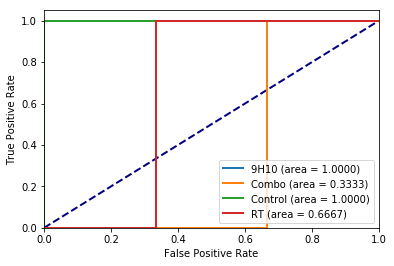

In [3]:
DTCR_WF.AUC_Curve()

You might notice that given how small this dataset is, doing one training split does not give us a good assesment for how predictive the TCR signature may be. In this case, we would want to use a K-fold cross validation to train on 19 of the samples and test on 1 and iterate until we've covered the entire cohort. When calling the K-fold cross validation command, one can provide the number of folds or if none is provided, it assumes a leave-one-out strategy.

In [4]:
%%capture
DTCR_WF.K_Fold_CrossVal()

We can then assess the performance once again through plotting the ROC curves.

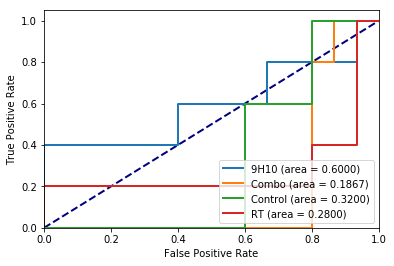

In [5]:
DTCR_WF.AUC_Curve()

Once our algorithm has been trained, we may want to see which sequences are the most strongly predicted for each label. To do this we will run the following command. The output of the command is a dictionary of dataframes within the object we can view. Additionally, these dataframes can be found in the results folder underneath the subdirectory 'Rep_Sequences'.

In [6]:
DTCR_WF.Representative_Sequences()

In [7]:
print(DTCR_WF.Rep_Seq['Control'])

      alpha            beta      v_beta      d_beta      j_beta v_alpha  \
11547  None   CGARENSGNTLYF  TCRBV20-01  unresolved  TCRBJ01-03    None   
11919  None     CASSIGNTLYF  TCRBV19-01  unresolved  TCRBJ01-03    None   
11659  None   CGARADSGNTLYF  TCRBV20-01  unresolved  TCRBJ01-03    None   
11706  None    CASRVSGNTLYF  TCRBV19-01  unresolved  TCRBJ01-03    None   
11546  None    CGAREGTYEQYF  TCRBV20-01  unresolved  TCRBJ02-07    None   
11665  None     CGARANSDYTF  TCRBV20-01  unresolved  TCRBJ01-02    None   
11520  None    CGASRRGSDYTF  TCRBV20-01  unresolved  TCRBJ01-02    None   
12086  None  CASSIANSGNTLYF  TCRBV19-01  unresolved  TCRBJ01-03    None   
11239  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
11749  None   CASSMGVYAEQFF  TCRBV19-01  unresolved  TCRBJ02-01    None   

      j_alpha    Class         Sample      Freq  Counts           HLA  \
11547    None  Control  CONTROL-4.tsv  0.000677       2  [N, o, n, e]   
11919    None  Control  CONT

Furthermore, we may want to know which learned motifs are associated with a given label. To do this, we can run the following command with the label we want to know the predictive motifs for.

In [8]:
DTCR_WF.Motif_Identification('Control')

Motif Identification Completed


The motifs can then be found in fasta files in the results folder underneath (label)(alpha/beta)Motifs. These fasta fiels can then be used with "https://weblogo.berkeley.edu/logo.cgi" for motif visualization.

# Visualization

We can also visualize the learned latent space from the supervised repertoire classifier through plotting a UMAP representation of the sequences in two dimensions. This is called in the exact same way as the supervised sequence classifier. See that tutorial for more details on using this method.  

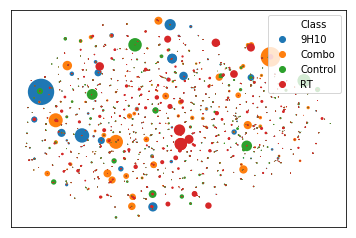

In [ ]:
DTCR_WF.UMAP_Plot(by_class=True,freq_weight=True,scale=1000)

We can also visualize how the repertoires are related from this learned representation. This visualiztion is helpful when we want to compare how different TCR repertoires are related structurally. Once again, this is called in the same exact way as with the supervised sequence classifier. 

In [ ]:
DTCR_WF.Repertoire_Dendrogram()

UMAP transformation...
PhenoGraph Clustering...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm


## "On-Graph" Clustering

We have also included an option within the supervised repertoire classifier which can improve performance in certain settings. This is an "on-graph" clustering method which learns a clustering solution guided by the supervised objective. The proportional use of this clustering solution is what is used to predict the label on the repertoire. To train DeepTCR with this option, we will set the 'on_graph_clustering' parameter to True.

In [ ]:
%%capture
DTCR_WF.K_Fold_CrossVal(on_graph_clustering=True)

We can then assess performance via AUC.

In [ ]:
DTCR_WF.AUC_Curve()

We note improvements in classification accuracy, in particular for the 9H10 and Combo therapies.

Once again, we can view the repertoire dendrogram to see these samples in this new 'clustering' feature space.

In [ ]:
DTCR_WF.Repertoire_Dendrogram()

Let's change the granularity of the hexbins to better appreciate the distribution of the repertoire.

In [ ]:
DTCR_WF.Repertoire_Dendrogram(Load_Prev_Data=True,gridsize=5)